**Initialization**

The next few steps(or code snippets) initialize the colab environment for running the fast.ai course. Each line of code that added are in place to avoid any error, please do not change the position of any snippet if you do not know what they do.

Note:- You will get an error saying that the code is closing in the memory limit of 12Gb. You can click 'terminate other runtimes'.
       This error is popping up because the dataset is taking up most of the space, so don't worry
      

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
# http://pytorch.org/
# pre installation
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl torchvision fastai
import torch

plotnine 0.4.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


In [3]:
#@title
!mkdir -p data && wget -q http://files.grouplens.org/datasets/movielens/ml-latest-small.zip && unzip -qq ml-latest-small.zip -d data/

replace data/ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Movielens

In [0]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [0]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [7]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [8]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [0]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [0]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [11]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.814093   0.809851  
    1      0.773127   0.781133  
    2      0.596628   0.765896  



[array([0.7659])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [12]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [0]:
preds = learn.predict()

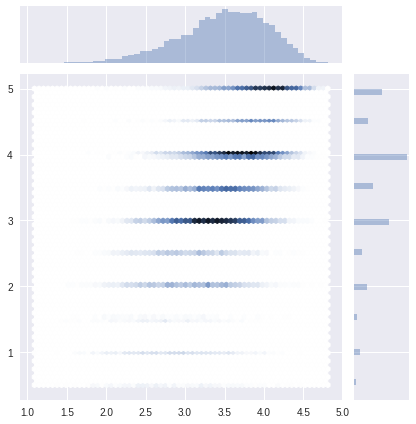

In [14]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [0]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [16]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [0]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [18]:
movie_bias

array([[ 0.84709],
       [ 0.87448],
       [ 1.3271 ],
       ...,
       [ 0.34872],
       [-0.00952],
       [ 0.19517]], dtype=float32)

In [0]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [20]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.92658275, 'Battlefield Earth (2000)'),
 (-0.7169637, 'Batman & Robin (1997)'),
 (-0.7130065, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.7125808, 'Wild Wild West (1999)'),
 (-0.7081583, 'Super Mario Bros. (1993)'),
 (-0.7075122, 'Speed 2: Cruise Control (1997)'),
 (-0.7018496, 'Anaconda (1997)'),
 (-0.6857145, 'Inspector Gadget (1999)'),
 (-0.63308793, 'Jaws 3-D (1983)'),
 (-0.6216595, 'Hollow Man (2000)'),
 (-0.5970961, "Joe's Apartment (1996)"),
 (-0.5883046, 'Message in a Bottle (1999)'),
 (-0.57434773, 'Flintstones, The (1994)'),
 (-0.5714112, 'Congo (1995)'),
 (-0.56774807, 'Bio-Dome (1996)')]

In [21]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.92658275, 'Battlefield Earth (2000)'),
 (-0.7169637, 'Batman & Robin (1997)'),
 (-0.7130065, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.7125808, 'Wild Wild West (1999)'),
 (-0.7081583, 'Super Mario Bros. (1993)'),
 (-0.7075122, 'Speed 2: Cruise Control (1997)'),
 (-0.7018496, 'Anaconda (1997)'),
 (-0.6857145, 'Inspector Gadget (1999)'),
 (-0.63308793, 'Jaws 3-D (1983)'),
 (-0.6216595, 'Hollow Man (2000)'),
 (-0.5970961, "Joe's Apartment (1996)"),
 (-0.5883046, 'Message in a Bottle (1999)'),
 (-0.57434773, 'Flintstones, The (1994)'),
 (-0.5714112, 'Congo (1995)'),
 (-0.56774807, 'Bio-Dome (1996)')]

In [22]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3271029, 'Shawshank Redemption, The (1994)'),
 (1.1674513, 'Godfather, The (1972)'),
 (1.0488297, 'Usual Suspects, The (1995)'),
 (0.9501025, 'Godfather: Part II, The (1974)'),
 (0.94562376, "Schindler's List (1993)"),
 (0.93235403, 'Fargo (1996)'),
 (0.89398134, 'Princess Bride, The (1987)'),
 (0.88672304, '12 Angry Men (1957)'),
 (0.88666296, 'Dark Knight, The (2008)'),
 (0.8744787, 'Pulp Fiction (1994)'),
 (0.84709436, 'Forrest Gump (1994)'),
 (0.8419705, 'Silence of the Lambs, The (1991)'),
 (0.8238199, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.814556, 'Rear Window (1954)'),
 (0.80908984, 'To Kill a Mockingbird (1962)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [23]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [25]:
movie_pca.shape

(3, 3000)

In [0]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [27]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.0748648, 'Pulp Fiction (1994)'),
 (0.067012206, 'Being John Malkovich (1999)'),
 (0.06494048, 'Goodfellas (1990)'),
 (0.06399871, 'Apocalypse Now (1979)'),
 (0.063683785, 'Fargo (1996)'),
 (0.06240465, 'Taxi Driver (1976)'),
 (0.06120869, '2001: A Space Odyssey (1968)'),
 (0.06092186, 'Chinatown (1974)'),
 (0.060390476, 'Full Metal Jacket (1987)'),
 (0.059391852, 'Godfather, The (1972)')]

In [28]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.081905656, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.067392305, 'Armageddon (1998)'),
 (-0.06071082, 'Mission: Impossible II (2000)'),
 (-0.058770295, 'Police Academy 3: Back in Training (1986)'),
 (-0.05820271, 'Waterworld (1995)'),
 (-0.057661768, 'Lost in Space (1998)'),
 (-0.057333887, 'Miss Congeniality (2000)'),
 (-0.0529592, 'Man in the Iron Mask, The (1998)'),
 (-0.052421413, 'Home Alone 3 (1997)'),
 (-0.05172587, 'Lost World: Jurassic Park, The (1997)')]

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [30]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.13113573, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.12278012, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.121389315, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.11740691, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.10265454, 'Matrix, The (1999)'),
 (0.09896215, 'Lethal Weapon (1987)'),
 (0.09785297, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.09635479,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.094043314, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.08387991, 'Forrest Gump (1994)')]

In [31]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.054945692, 'Stepford Wives, The (1975)'),
 (-0.047687177, 'Leaving Las Vegas (1995)'),
 (-0.04644712, 'Mulholland Drive (2001)'),
 (-0.046221506, 'Space Jam (1996)'),
 (-0.046169367, 'Pieces of April (2003)'),
 (-0.04288475, 'Friday the 13th Part 3: 3D (1982)'),
 (-0.042447466,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.042090956, 'Bringing Up Baby (1938)'),
 (-0.04192074, '8 1/2 (8½) (1963)'),
 (-0.040324356, 'Home Alone 2: Lost in New York (1992)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

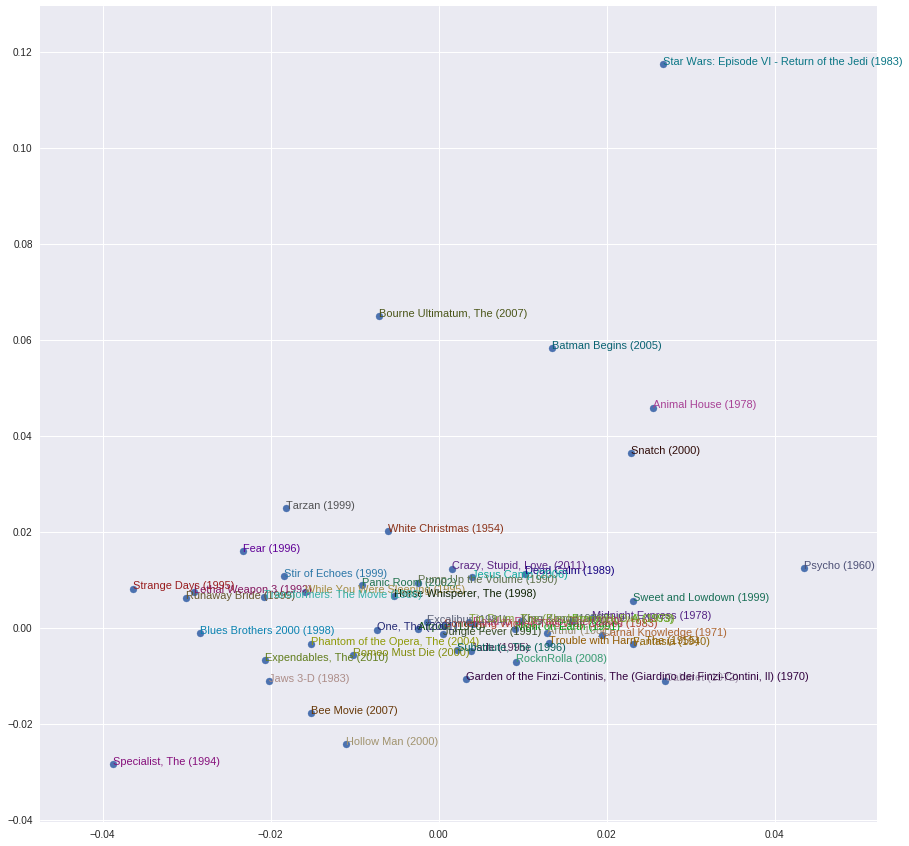

In [32]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [33]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [34]:
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [35]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [0]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [0]:
model=DotProduct()

In [38]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [0]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [0]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [0]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [0]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [0]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [44]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      1.694518   1.636231  
    1      1.061668   1.299865  
    2      0.955639   1.225609  



[array([1.22561])]

In [0]:
set_lrs(opt, 0.01)

In [46]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.716424   1.147718  
    1      0.698611   1.13465   
    2      0.670888   1.130182  



[array([1.13018])]

### Bias

In [47]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [0]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [50]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.849339   0.837104  
    1      0.811242   0.814318  
    2      0.769739   0.811844  



[array([0.81184])]

In [0]:
set_lrs(opt, 1e-2)

In [52]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.73834    0.803762  
    1      0.748575   0.801889  
    2      0.751373   0.801111  



[array([0.80111])]

### Mini net

In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [55]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.921004   0.807385  
    1      0.840737   0.790992  
    2      0.791038   0.785069  



[array([0.78507])]

In [0]:
set_lrs(opt, 1e-3)

In [57]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.788819   0.791403  
    1      0.801915   0.790946  
    2      0.759726   0.79143   



[array([0.79143])]